In [5]:
!pip install elasticsearch  #to install elasticsearch
!pip install elasticsearch_dsl

In [0]:
#!/usr/bin/env python3
import csv

import time
import datetime
from calendar import timegm
import os
import sys
import re
import pandas as pd
from dateutil.parser import parse
from elasticsearch import helpers
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search


import urllib3
urllib3.disable_warnings()
from urllib.parse import urlencode

from dateutil.parser import parse


'''
process the incoming events
and return a list of processed events
Parameters
     client:  ElasticSearch client
     start_dt : start time for query processing
     end_dt: end times for query processing
     index: index of where to store the new events
'''
def read_processed_events(client, start_dt,end_time,index):
     
    start_time = start_dt.strftime('%Y-%m-%dT%H:%M:%S')
    print('Quering for data starting with ' + start_time)
    
    s = Search(using=client, index=index) \
               .filter('range', ** {'@timestamp': {'gt': start_time, 'lt':end_time}}) 

    
    s = s[:s.count()]
    if len(list(s)) == 0:
        return []
    else: 
        print(len(list(s)))
      
    try:
        response = s.execute()
        if not response.success():
            raise
    except Exception as e:
        print(e, 'Error accessing Elasticsearch')
        sys.exit(1)
    data = []
    for entry in response.to_dict()['hits']['hits']:
        data.append(entry['_source'])
       
    return data



In [7]:

  #connecting to ElasticSerch Client 
client = Elasticsearch('https://galactica.isi.edu/es/', http_auth = ('', ''),timeout=60000,max_retries=10)

# the number of days data that needs to be collected 
start_dt = datetime.datetime.utcnow() - datetime.timedelta(days=14)
end_dt = datetime.datetime.utcnow()

current_dt = start_dt
print(current_dt,end_dt)

#index to read events from
index = "processed-composite-workflow-events*"

time_delta = current_dt + datetime.timedelta(hours =5)

output_rows = []
while time_delta < end_dt:

    #read data for  intital 5 hours from starting from last 14 days
    events = read_processed_events(client, current_dt,time_delta,index)

    if events!= []:
        output_rows = output_rows + events   
    current_dt = time_delta + datetime.timedelta(seconds = 1)
    time_delta = time_delta + datetime.timedelta(hours = 5)


  #Thus df is dataframe that is list of dictionary type that stores the events read from processed index 
df = pd.DataFrame.from_dict(output_rows)

2019-04-26 00:25:39.516595 2019-05-10 00:25:39.516630
Quering for data starting with 2019-04-26T00:25:39
2445
Quering for data starting with 2019-04-26T05:25:40
1365
Quering for data starting with 2019-04-26T10:25:40
1
Quering for data starting with 2019-04-26T15:25:40
25
Quering for data starting with 2019-04-26T20:25:40
16
Quering for data starting with 2019-04-27T01:25:40
603
Quering for data starting with 2019-04-27T06:25:40
842
Quering for data starting with 2019-04-27T11:25:40
Quering for data starting with 2019-04-27T16:25:40
Quering for data starting with 2019-04-27T21:25:40
Quering for data starting with 2019-04-28T02:25:40
663
Quering for data starting with 2019-04-28T07:25:40
235
Quering for data starting with 2019-04-28T12:25:40
Quering for data starting with 2019-04-28T17:25:40
Quering for data starting with 2019-04-28T22:25:40
Quering for data starting with 2019-04-29T03:25:40
867
Quering for data starting with 2019-04-29T08:25:40
31
Quering for data starting with 2019-04

In [10]:
#Counting total integrity errors that occurred in the data
integrity_err_count = df['checksum_failure'].sum()
print("Total integrity errors ",integrity_err_count)
print(df.columns)

Total integrity errors  59
Index(['@timestamp', 'actual_checksum', 'checksum_failure', 'dest_proto_host',
       'end_time', 'executable', 'execution_hostname', 'execution_site',
       'expected_checksum', 'filename', 'job_exitcode', 'job_id', 'job_type',
       'local_dur', 'origin_id', 'retry_attempt', 'root_xwf_id', 'source_id',
       'source_proto_host', 'start_time', 'submit_hostname', 'user_remote',
       'user_submit'],
      dtype='object')


In [8]:
print(df.head())

                 @timestamp actual_checksum  checksum_failure  \
0  2019-04-26T00:25:52.000Z                                 0   
1  2019-04-26T00:25:52.000Z                                 0   
2  2019-04-26T00:25:52.000Z                                 0   
3  2019-04-26T00:25:52.000Z                                 0   
4  2019-04-26T00:25:52.000Z                                 0   

     dest_proto_host    end_time  executable execution_hostname  \
0  compute-1-5.tier2  1556241137           1  compute-1-5.tier2   
1  compute-1-5.tier2  1556241137           1  compute-1-5.tier2   
2  compute-1-5.tier2  1556241137           1  compute-1-5.tier2   
3  compute-1-5.tier2  1556241137           1  compute-1-5.tier2   
4  compute-1-5.tier2  1556241137           1  compute-1-5.tier2   

  execution_site expected_checksum          filename  ... local_dur  \
0     condorpool                    determine_rse.py  ...      2785   
1     condorpool                          run-pax.sh  ...      2

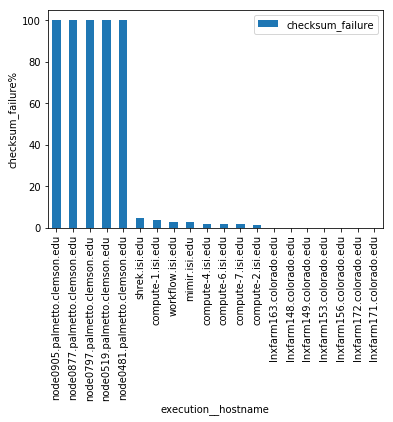

In [17]:
#top hosts with the %of checksum failures happening at these nodes where integrity error occurred mostly
top_integrity_err_exec_host = df.groupby(["execution_hostname"])["checksum_failure"].agg('mean').apply(lambda x:x*100).sort_values(ascending=False)#.filter(lambda x :x["checksum__failure"]!=0)
#top_integrity_err_exec_host =pd.DataFrame(index=top_integrity_err_exec_host.index,values=top_integrity_err_exec_host)
top_integrity_err_exec_host [:20]
top_integrity_err_exec_host[:20].plot.bar()
import matplotlib.pyplot as plt  

plt.xlabel("execution__hostname") 
plt.ylabel("checksum_failure%") 
plt.legend()
plt.show() 

#This chart denotes % of events (y-axis) occurring at the execution_site(on x_axis) having checksum failure  

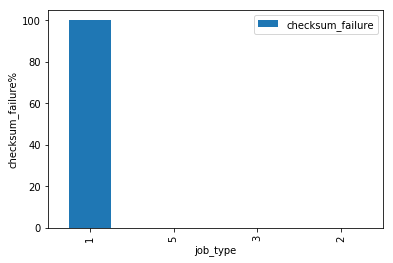

In [33]:
#job types where integrity errors occurred
top_integrity_err_jobtype = df.groupby(["job_type"])["checksum_failure"].agg('sum').apply(lambda x:x/integrity_err_count*100).sort_values(ascending=False)#.filter(lambda x :x["checksum__failure"]!=0)
top_integrity_err_jobtype.plot.bar()
import matplotlib.pyplot as plt  
# # plot between 2 attributes 


plt.xlabel("job_type") 
plt.ylabel("checksum_failure%") 
plt.legend()
plt.show() 

#This chart denotes of all the checksum failure in collected data how many checksum failures had a specific job_type, so all the failures have job_type 1

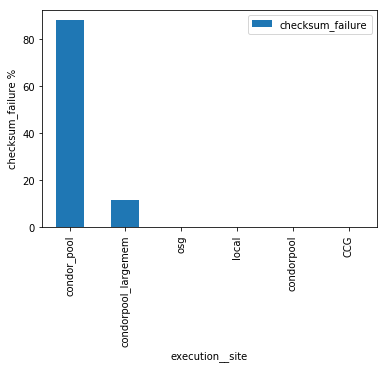

In [34]:
#execution sites where integrity errors occurred
top_integrity_err_jobtype = df.groupby(["execution_site"])["checksum_failure"].agg('sum').apply(lambda x:x/integrity_err_count*100).sort_values(ascending=False)#.filter(lambda x :x["checksum__failure"]!=0)
top_integrity_err_jobtype.plot.bar()
import matplotlib.pyplot as plt  
# # plot between 2 attributes 


plt.xlabel("execution__site") 
plt.ylabel("checksum_failure %") 
plt.legend()
plt.show() 

#This chart denotes of all the checksum failure in collected data how many checksum failures had a specific execution_site, 
#so 90% checksum failures occur at site condor_pool while 10% checksum failures occir at site condorpool_largemem

In [39]:
top_integrity_err_root = df.groupby(["filename","actual_checksum","execution_hostname"])["checksum_failure"].agg('sum').reset_index().sort_values(by = ["checksum_failure"],ascending = False)#.filter(lambda x :x["checksum__failure"]!=0)
top_integrity_err_root = top_integrity_err_root[top_integrity_err_root["checksum_failure"]>0]
top_integrity_err_root

,filename,actual_checksum,execution_hostname,checksum_failure
2592,keg,c32f0fcafa766cd79f6d9aef720665322b921095f6aa45...,shrek.isi.edu,5
2589,keg,c32f0fcafa766cd79f6d9aef720665322b921095f6aa45...,compute-6.isi.edu,5
2591,keg,c32f0fcafa766cd79f6d9aef720665322b921095f6aa45...,mimir.isi.edu,2
2590,keg,c32f0fcafa766cd79f6d9aef720665322b921095f6aa45...,compute-7.isi.edu,2
117,1-17-1.data,fb1b5a602942f71e0d2a2939a069417d2e98724a797fa0...,compute-6.isi.edu,1
210,1-22-2.data,dd6d87073a3c38b20b3a345d80a9bb2377851743f958be...,compute-2.isi.edu,1
209,1-22-2.data,67ee7aa5ad8fcb9c28a58aececc8b4637c17ced53a2b01...,compute-6.isi.edu,1
2588,keg,c32f0fcafa766cd79f6d9aef720665322b921095f6aa45...,compute-4.isi.edu,1
160,1-19-2.data,dd6d87073a3c38b20b3a345d80a9bb2377851743f958be...,compute-7.isi.edu,1
159,1-19-2.data,67ee7aa5ad8fcb9c28a58aececc8b4637c17ced53a2b01...,workflow.isi.edu,1


In [42]:
#for each workflow what are the execution hosts where integrity errors occurred
top_integrity_err_exec_host = df.groupby(['root_xwf_id',"execution_hostname"])["checksum_failure"].agg('sum').reset_index().sort_values(by = ["root_xwf_id","checksum_failure"],ascending = False)#.filter(lambda x :x["checksum_failure"]!=0)
top_integrity_err_exec_host = top_integrity_err_exec_host[top_integrity_err_exec_host["checksum_failure"]>0]
top_integrity_err_exec_host[:20]

,root_xwf_id,execution_hostname,checksum_failure
474,ef75c71f-c8b9-4011-9aea-953baabcd709,compute-7.isi.edu,7
473,ef75c71f-c8b9-4011-9aea-953baabcd709,compute-6.isi.edu,2
470,ef75c71f-c8b9-4011-9aea-953baabcd709,compute-2.isi.edu,1
432,cd3b7c48-63a8-460b-a2f9-d3c2df42f175,compute-7.isi.edu,5
431,cd3b7c48-63a8-460b-a2f9-d3c2df42f175,compute-6.isi.edu,3
434,cd3b7c48-63a8-460b-a2f9-d3c2df42f175,shrek.isi.edu,3
433,cd3b7c48-63a8-460b-a2f9-d3c2df42f175,mimir.isi.edu,2
373,ad30ae9d-5aac-4131-b9b2-b04e725ff175,compute-7.isi.edu,5
372,ad30ae9d-5aac-4131-b9b2-b04e725ff175,compute-6.isi.edu,4
376,ad30ae9d-5aac-4131-b9b2-b04e725ff175,workflow.isi.edu,2


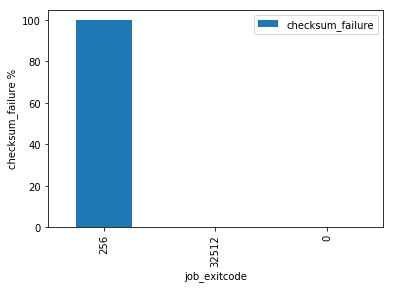

In [46]:
#job exit codes where integrity errors occurred
top_integrity_err_jobtype = df.groupby(["job_exitcode"])["checksum_failure"].agg('sum').apply(lambda x:x/integrity_err_count*100).sort_values(ascending=False)#.filter(lambda x :x["checksum__failure"]!=0)
top_integrity_err_jobtype.plot.bar()
import matplotlib.pyplot as plt  
# # plot between 2 attributes 


plt.xlabel("job_exitcode") 
plt.ylabel("checksum_failure %") 
plt.legend()
plt.show() 
#This chart denotes of all the checksum failure in collected data how many checksum failures had a specific job_exitcode, 


In [53]:
!pip install kmodes
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


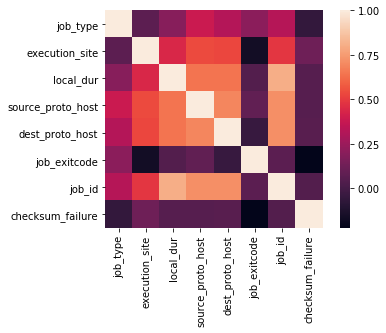

In [54]:
import numpy as np


#plotting heat map to compute correlation between different variables
Sum_of_squared_distances = []
costs= []
X = df[['job_type','execution_site','local_dur','source_proto_host','dest_proto_host','job_exitcode','job_id','checksum_failure']]
X.fillna(0,inplace=True)

# It is required to convert values in string format to numerical categories before using any correlation
X.loc[:,:]=X.apply(lambda x : pd.factorize(x)[0])   

cor = X.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True)


In [55]:

#running clustering on chosen parameters
from kmodes import kmodes
from kmodes.util.dissim import matching_dissim
K = range(1,15)
#choosing subset of variables only
X = X[['job_type','execution_site','local_dur','source_proto_host','dest_proto_host','job_exitcode','job_id']]
kmodes_cao_k = []
for k in K:
    kmodes_cao = kmodes.KModes(n_clusters=k, init='Cao', verbose=1)
    kmodes_cao_k.append(kmodes_cao)
    kmodes_cao.fit_predict(X)
    labels,cost =  kmodes._labels_cost(X, kmodes_cao.cluster_centroids_,matching_dissim)
    costs.append(cost)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 36166.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 505, cost: 30903.0
Run 1, iteration: 2/100, moves: 0, cost: 30903.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 639, cost: 27525.0
Run 1, iteration: 2/100, moves: 0, cost: 27525.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 746, cost: 24581.0
Run 1, iteration: 2/100, moves: 844, cost: 23914.0
Run 1, iteration: 3/100, moves: 14, cost: 23914.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1238, cost: 23311.0
Run 1, iteration: 2/100, moves: 34, cost: 23311.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration:

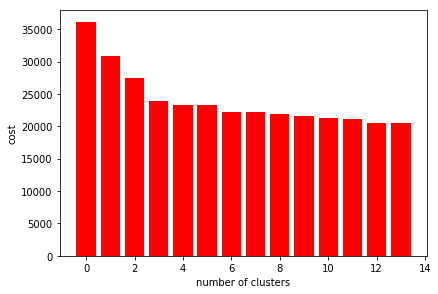

In [56]:
import numpy as np
import matplotlib.pyplot as plt

indices = np.arange(len(costs))
plt.bar(indices, costs,color='r')
#choosing the optimal cost
plt.tight_layout()
plt.xlabel("number of clusters")
plt.ylabel("cost")
plt.show()

In [0]:
%matplotlib inline
y_kmodes = kmodes_cao_k[2].predict(X)
centroids = kmodes_cao_k[2].cluster_centroids_
labels= kmodes_cao_k[2].labels_
kmodes = pd.DataFrame(labels)


{2: 'condorpool', 4: 'local', 1: 'condor_pool', 0: 'CCG', 3: 'condorpool_largemem', 5: 'osg'}


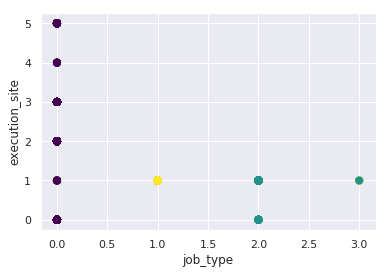

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
fig = plt.figure()
label_dict=df['execution_site'].astype('category')
label_dict = dict(zip(label_dict.cat.codes,label_dict))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmodes, s=50, cmap='viridis')
# ax.set_yticks(label_dict.keys())
# ax.set_yticklabels(label_dict.values())
ax.set_xlabel('job_type')
ax.set_ylabel('execution_site')
print(label_dict)
#plotting the clustering result 
#plt.scatter(centroids[:, 0], centroids[:, 1], c='green', s=200, alpha=0.5);

In [62]:
checksum_centroids = {0:0,1:0,2:0}

df1 = df[['checksum_failure']]
print(df1.iloc[0,0])
for i in range(len(df)):
  
  if df1.iloc[i,0] == 1:
    checksum_centroids[labels[i]] += 1
                     
  
print(checksum_centroids)  
total_elements = []
for i in range(3):
  checksum_centroids[i] = checksum_centroids[i]
  total_elements.append(sum(labels==i))
  
for i in range(3):
  print("total events in cluster "+str(i),total_elements[i])
  print("total checksum failure events in the cluster "+str(i),checksum_centroids[i])


0
{0: 59, 1: 0, 2: 0}
total events in cluster 0 5384
total checksum failure events in the cluster 0 59
total events in cluster 1 1580
total checksum failure events in the cluster 1 0
total events in cluster 2 1178
total checksum failure events in the cluster 2 0
